# TMDB Movie Data Analysis
### By Georgia Maria Dias 

<img src = "https://images.unsplash.com/photo-1616530940355-351fabd9524b?w=600&auto=format&fit=crop&q=60&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8Mnx8bW92aWVzfGVufDB8fDB8fHww" />

## Over-view
* Top genres 
* Time-period 
* Budgets over time
* Identify and explore anomalies 

Importing necessary packages 

In [69]:
import pandas as pd 
import numpy as np 
import ast 
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import datetime

Loading in the dataset 
Note: we duplicate the dataframe so there is always an uneditied version available for reference 

In [74]:
Movies = pd.read_csv("C:\\Users\\cex\\OneDrive\\Documents\\Digital Futures\\TMDB Project\\TMDB_movies.csv")
df = Movies.copy()

 release_date was converted into a datetime object and the year was extracted into a new column

In [75]:
df['release_date'] = pd.to_datetime(df['release_date'], format='%d/%m/%Y')
df['release_year'] = df['release_date'].dt.year

## Dictionary columns 
One of the biggest problems when dealing with this data was the presence of dictionaries in 5 columns. To make this data more manageable the values were extracted into a list. 

Columns with dictionaries were parsed using Abstract Syntax Tree's (ast) literal_eval() function to extract the items into a list. 

In [76]:
columns = ['genres', 'keywords', 'production_companies', 'production_countries', 'spoken_languages']
for col in columns: 
    df[col] = df[col].apply(lambda x: ast.literal_eval(x))
    df[col] = df[col].apply(lambda x: [col['name'] for col in x])

## Missing Values 
Another issue with this dataset was the presence of missing values. Although upon initial inspection it seems like 'homepage' and 'tagline' are the only columns with missing values but this is incorrect.

We have some hidden null values...

In [77]:
df.isnull().sum()

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
release_year               1
dtype: int64

### Budget 
This column has lots of 0 values, which we can interpret to be null values. So that the 0 values do not interfer with out analysis, we will replace them with NaN then drop the columns with NaN values. 

Although this is a significant portion of our dataset, because our analysis is focussed on budgets we do not want to risk the integrity of our data.

In [78]:
df['budget'] = df['budget'].replace(0, np.nan)

df_budgets = df.dropna(subset='budget', axis=0).copy()

## Dictionary Columns 
When we collapsed the disctionaries into a list, those with no values were assigned an empty list which does not count as a NaN value but does not hold any information. We can see how many of these occurances we have

In [80]:
for col in columns:
    print(col)
     
    nulls = df[df[col].apply(lambda x:len(x) == 0 )]
    print('Number of Empty lists:', len(nulls))
    percent_empty = round((100 * len(nulls) / len(df) ), 2)
    print('Percentage of empty lists', percent_empty)

genres
Number of Empty lists: 28
Percentage of empty lists 0.58
keywords
Number of Empty lists: 412
Percentage of empty lists 8.58
production_companies
Number of Empty lists: 351
Percentage of empty lists 7.31
production_countries
Number of Empty lists: 174
Percentage of empty lists 3.62
spoken_languages
Number of Empty lists: 86
Percentage of empty lists 1.79


## Dropping empty genre lists

For keywords, production_companies, production_countries and spoken_languages we will not be using these for our analysis so imputing values is not important. 

But for genres we are using those values in our analysis. The null values only account for 0.58% of our dataset so we can drop those rows. 

To do that, we must first convert the empty lists to NaN so that the dropna() method will work on these rows

In [81]:
def replace_empty_lists(list):
    if len(list) == 0:
        return np.nan
    else:
        return list 

df['genres'] = df['genres'].apply(replace_empty_lists)

print('Number of NaN:', df.genres.isnull().sum())

Number of NaN: 28


The dropna() method will drop rows with NaN values in the genres column 

In [82]:
df = df.dropna(subset = 'genres', axis = 0)

print('Number of NaN:', df.genres.isnull().sum())

Number of NaN: 0


<img src = 'https://plus.unsplash.com/premium_photo-1679329103257-7157a96ff68b?q=80&w=1932&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D' />

## EXPLODING the genres 
The genres list is exploded so that all occurances of genres are taken into account in our analysis. Then the columns are renamed. 

The rows are grouped by genre and year, and the mean budget is calculated per group. 

In [11]:
exploded_df = df.explode('genres')[['budget', 'genres', 'id', 'title', 'release_year', 'revenue']]
exploded_df.columns = ['budget', 'genre', 'id', 'title', 'year', 'revenue']

budget_genre_yearly = exploded_df.groupby(['genre', 'year'])['budget'].mean()
budget_genre_yearly = budget_genre_yearly.reset_index()

## Spread of Genres 
We will create a dataframe of Genre counts 

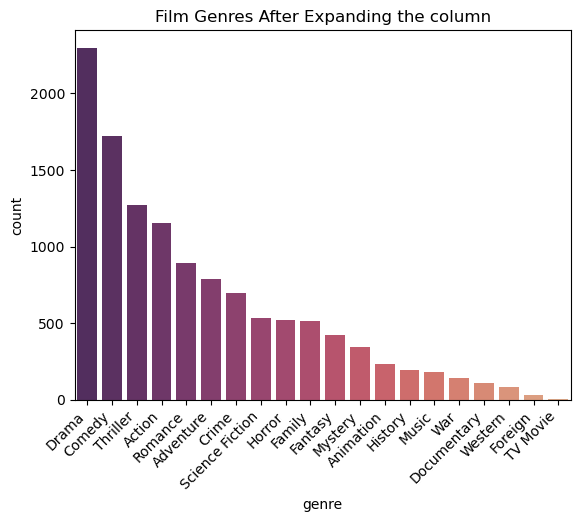

In [12]:
exploded_genres = exploded_df['genre'].value_counts()
#Turning that into a dataframe 
exploded_genres = pd.DataFrame(exploded_genres)
#Reset the Index 
exploded_genres.reset_index(inplace=True)
#And rename the columns 
col_names = ['genre', 'count']
exploded_genres.columns = col_names 

#Plot the Graph 
sns.barplot(x = 'genre',
            y = 'count' ,
            data = exploded_genres, 
            palette = 'flare_r')
plt.xticks(rotation = 45, 
          horizontalalignment = 'right')
plt.title('Film Genres After Expanding the column')
plt.show()


### Keypoint 
The top genres are Drama, Comedgy and Thrillers

## Years covered in our dataset 


In [13]:
print('From ', df.release_year.min(), ' to ', df.release_year.max())

From  1916.0  to  2017.0


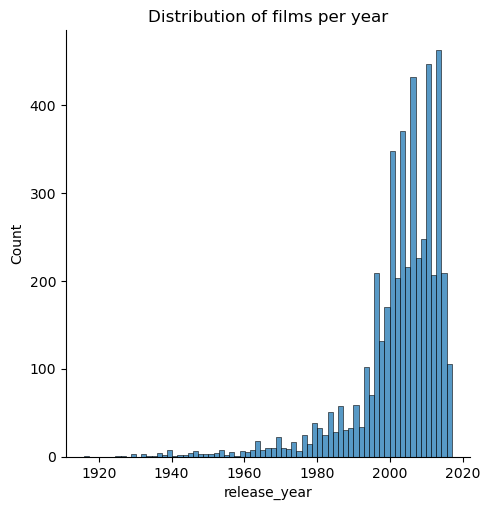

In [87]:
sns.displot(x= 'release_year', 
            data = df)
plt.title('Distribution of films per year')
plt.show()

### Keypoint
The early years of our dataset do not contain many films, but the number of films increases as the years go on. 

## Drama is our top genre
So let's zoom in. 
We will look at the annual budgets of Drama films throughout the dataset throughout the entire time period. 

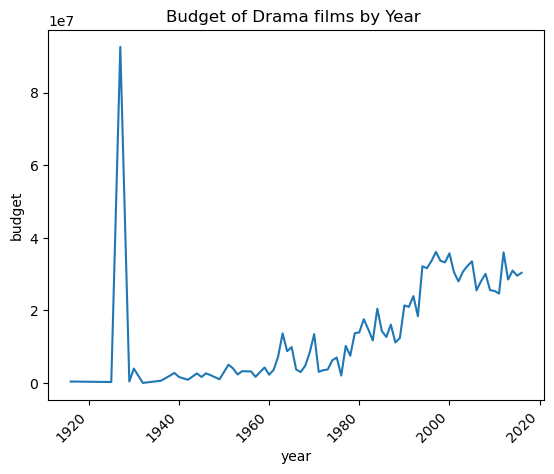

In [16]:
#Subset the DF to zoom in Dramas 
drama_yearly_budget = budget_genre_yearly[budget_genre_yearly['genre'] == 'Drama']
#Plot the graph 
sns.lineplot(x = 'year', 
             y = 'budget', 
             data = drama_yearly_budget, 
             palette = 'flare_r')
plt.xticks(rotation = 45, 
           horizontalalignment = 'right')
plt.title('Budget of Drama films by Year ')
plt.show()

### Now what is up with that peak???

In [57]:
peaks = exploded_df[(exploded_df['year'] == 1927) & (exploded_df['genre'] =='Drama')]
print('The film causing the peak is' ,peaks.iloc[0, 3])
print('With a budget of $', peaks.iloc[0, 0])
print('or more than 5000000 Reichsmarks') 

The film causing the peak is Metropolis
With a budget of $ 92620000.0
or more than 5000000 Reichsmarks


<img src = 'https://m.media-amazon.com/images/M/MV5BMTg5YWIyMWUtZDY5My00Zjc1LTljOTctYmI0MWRmY2M2NmRkXkEyXkFqcGdeQXVyMTMxODk2OTU@._V1_.jpg' />

Metropolis is a 1927 German Sci-Fi film directed by Von Fritz Lang. It is a silent film about a futuristic society where the rich live in a lush utopia and the poor work underground in harsh conditions. What this film lacks in recorded sound it makes up for in elaborate sets and an extensive cast dressed in highly styleised outfits.  

At the time of it's release, Metropolis was the most expensive film ever made. Lang had elaborate sets constructed, employed crowds of extras and used advanced (for-the-time) special effects techniques. 

It's very impressive that this film continues to be an outlier despite that fact it was released almost 100 years ago. 


### Keypoint 
Metropolis is a promenitent outlier in our dataset. 

It's budget continues to sit above the rest despite being a silent film made nearly 100 years ago.

## How does the budget of Metropolis compare to other Drama films? 


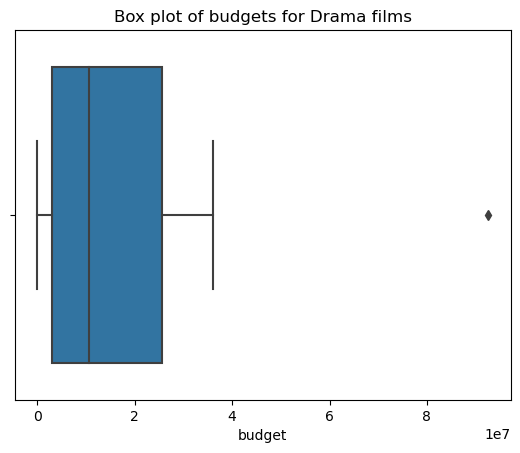

In [17]:
plt.clf()
sns.boxplot(data=drama_yearly_budget, 
            x= 'budget')
plt.title('Box plot of budgets for Drama films')
plt.show()


## Comedy is our second top genre 


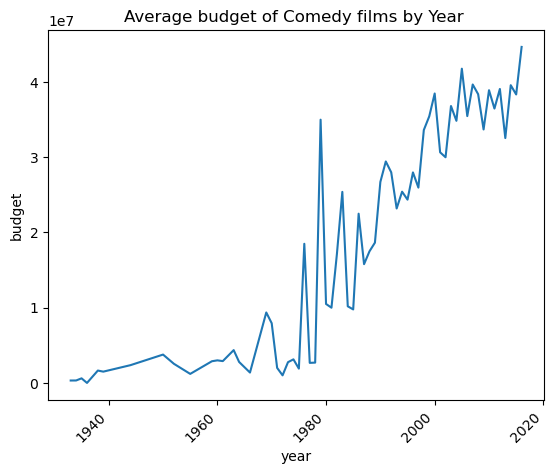

In [89]:
comedy_yearly_budget = budget_genre_yearly[budget_genre_yearly['genre'] == 'Comedy']

plt.clf()
sns.lineplot(x = 'year', 
             y = 'budget', 
             data = comedy_yearly_budget, 
             palette = 'flare_r')
plt.xticks(rotation = 45, 
           horizontalalignment = 'right')
plt.title('Average budget of Comedy films by Year ')
plt.show()

Although the peak is not as pronounced as our peak for drama, we do have some unusual acitvity around the 1980s. 

Let's investigate 

In [19]:
#We also have a strange peak in 1979  
peak_range = comedy_yearly_budget[(comedy_yearly_budget['year'] > 1975) & (comedy_yearly_budget['year'] < 1985)]
peak_comedy = exploded_df[(exploded_df['year'] == 1979) & (exploded_df['genre'] =='Comedy')]
print('The film causing that peak is' , peak_comedy.iloc[0, 3])
print('With a budget of $', peak_comedy.iloc[0, 0])

The film causing that peak is 1941
With a budget of $ 35000000.0


<img src = 'https://upload.wikimedia.org/wikipedia/en/e/ed/1941_movie.jpg' />

1941 is a political comedy and one of Steven Speilburg's first films. 

It does not appear to be an outlier in our dataset. 

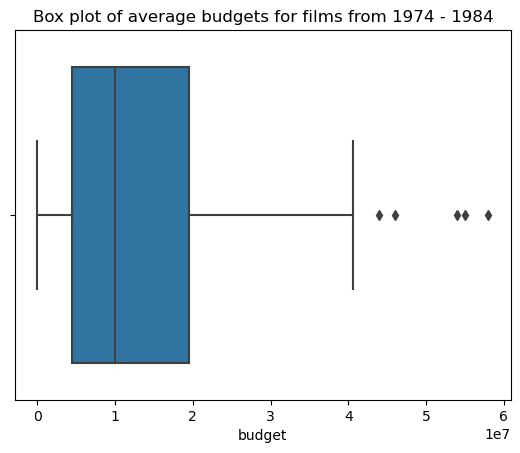

In [88]:
period_films = df[(df['release_year'] >= 1974) & (df['release_year'] <= 1984)]
plt.clf()
sns.boxplot(data= period_films ,
            x= 'budget')
plt.title('Box plot of average budgets for films from 1974 - 1984')
plt.show()


## Who are our outliers?

In [73]:
period_films.sort_values('budget', ascending=False)[['title', 'genres', 'budget']].head(5)

,title,genres,budget
1018,The Cotton Club,"[Music, Drama, Crime, Romance]",58000000.0
813,Superman,"[Action, Adventure, Fantasy, Science Fiction]",55000000.0
870,Superman II,"[Action, Adventure, Fantasy, Science Fiction]",54000000.0
1039,Inchon,"[Drama, History, War]",46000000.0
1109,Heaven's Gate,"[Action, Drama, History, Western]",44000000.0


### Conclusion 
The budgets of the top genres steadily increase with occassional large-budget films causing peaks 

![Movies](https://images.unsplash.com/photo-1509281373149-e957c6296406?q=80&w=1928&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D)